

# Informe de Fundamentos: Valuación DCF Probabilístico con Python

## 1. Introducción al DCF (Discounted Cash Flow)

### ¿Qué es el DCF?

El **Descuento de Flujos de Caja (DCF)** es el "estándar de oro" de la valoración financiera. Se basa en el principio fundamental de que un activo vale exactamente lo que es capaz de generar en efectivo en el futuro, traído al presente.

### ¿Para qué sirve?

Sirve para determinar el **Valor Intrínseco** de una empresa. A diferencia de los múltiplos (como el PER o EV/Revenue), que comparan una empresa con otras, el DCF mira el negocio hacia adentro: su capacidad de generar caja, su crecimiento y sus riesgos.

### ¿Qué necesitas saber previamente?

Para entender un DCF, es fundamental dominar tres conceptos:

1. **Valor del dinero en el tiempo:** Un dólar hoy vale más que un dólar mañana (debido a la inflación y al costo de oportunidad).
2. **Free Cash Flow (FCF):** El dinero real que queda en la caja después de pagar gastos operativos e inversiones (CapEx).
3. **WACC (Costo Promedio Ponderado de Capital):** La tasa de descuento que representa el riesgo del negocio. A mayor riesgo, mayor tasa, y por lo tanto, menor valor presente.

### ¿Cómo se hace realmente?

1. **Proyectar:** Estimar los ingresos y gastos futuros (generalmente a 5 o 10 años).
2. **Calcular el Valor Terminal:** Estimar cuánto valdrá la empresa al final del periodo de proyección.
3. **Descontar:** Traer todos esos flujos futuros al presente usando el WACC.
4. **Valor de Capital (Equity Value):** Al Valor de la Empresa (Enterprise Value) se le resta la deuda y se le suma la caja.

---

## 2. El Problema: El DCF Determinístico

En el código adjunto, la **Parte 1** ilustra el problema principal del análisis tradicional.

### El error de la "precisión falsa"

Un DCF determinístico asume que podemos predecir el futuro con un solo número (ej: *"La empresa crecerá exactamente al 25%"*).

* **El problema de los escenarios extremos:** Como muestra el código, un analista optimista puede llegar a un precio de acción 100% superior al de un analista conservador simplemente cambiando dos decimales en el crecimiento o el WACC.
* **Incertidumbre en empresas Growth:** En empresas como **Snowflake (SNOW)**, donde el crecimiento es explosivo pero los márgenes actuales son negativos, un pequeño error en la estimación del futuro cambia radicalmente el resultado hoy.

---




In [12]:
"""
DCF PROBABILÍSTICO PARA EMPRESAS GROWTH
========================================
Video: Valuación de Growth Companies con Monte Carlo en Python
Canal: Data Finance

Caso real: Snowflake (SNOW) - Empresa cloud growth
"""

# ============================================================================
# 1. INSTALACIÓN Y IMPORTS
# ============================================================================

# !pip install yfinance pandas numpy scipy matplotlib seaborn

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 70)
print("DCF PROBABILÍSTICO - EMPRESAS GROWTH")
print("=" * 70)


DCF PROBABILÍSTICO - EMPRESAS GROWTH


In [13]:
# ============================================================================
# 2. OBTENER DATOS REALES CON YFINANCE
# ============================================================================

def obtener_datos_empresa(ticker):
    """
    Obtiene datos fundamentales de Yahoo Finance
    """
    stock = yf.Ticker(ticker)
    
    # Información básica
    info = stock.info
    
    # Financials
    income_stmt = stock.income_stmt
    balance_sheet = stock.balance_sheet
    cashflow = stock.cashflow
    
    # Extraer métricas clave
    datos = {
        'ticker': ticker,
        'nombre': info.get('longName', ticker),
        'precio_actual': info.get('currentPrice', 0),
        'shares_outstanding': info.get('sharesOutstanding', 0),
        'market_cap': info.get('marketCap', 0),
        'enterprise_value': info.get('enterpriseValue', 0),
        'deuda_total': balance_sheet.loc['Total Debt'].iloc[0] if 'Total Debt' in balance_sheet.index else 0,
        'caja': balance_sheet.loc['Cash And Cash Equivalents'].iloc[0] if 'Cash And Cash Equivalents' in balance_sheet.index else 0,
        'revenue_actual': income_stmt.loc['Total Revenue'].iloc[0] if 'Total Revenue' in income_stmt.index else 0,
        'revenue_anterior': income_stmt.loc['Total Revenue'].iloc[1] if len(income_stmt.columns) > 1 and 'Total Revenue' in income_stmt.index else 0,
        'operating_income': income_stmt.loc['Operating Income'].iloc[0] if 'Operating Income' in income_stmt.index else 0,
        'sector': info.get('sector', 'N/A'),
        'industry': info.get('industry', 'N/A'),
        'beta': info.get('beta', 1.2)
    }
    
    # Calcular métricas derivadas
    if datos['revenue_anterior'] != 0:
        datos['crecimiento_historico'] = (datos['revenue_actual'] / datos['revenue_anterior'] - 1) * 100
    else:
        datos['crecimiento_historico'] = 25.0
    
    if datos['revenue_actual'] != 0:
        datos['margen_operativo'] = (datos['operating_income'] / datos['revenue_actual']) * 100
    else:
        datos['margen_operativo'] = -10.0
    
    datos['deuda_neta'] = datos['deuda_total'] - datos['caja']
    
    return datos

# Obtener datos de Snowflake (empresa cloud growth real)
print("\n📊 Obteniendo datos reales de Snowflake (SNOW)...")
print("-" * 70)

empresa = obtener_datos_empresa('SNOW')

# Mostrar datos obtenidos
print(f"\n🏢 Empresa: {empresa['nombre']}")
print(f"📈 Ticker: {empresa['ticker']}")
print(f"💰 Precio actual: ${empresa['precio_actual']:.2f}")
print(f"🔢 Acciones: {empresa['shares_outstanding']:,.0f}")
print(f"💵 Market Cap: ${empresa['market_cap']/1e9:.2f}B")
print(f"📊 Revenue actual: ${empresa['revenue_actual']/1e9:.2f}B")
print(f"📈 Crecimiento histórico: {empresa['crecimiento_historico']:.1f}%")
print(f"💹 Margen operativo: {empresa['margen_operativo']:.1f}%")
print(f"🏦 Deuda neta: ${empresa['deuda_neta']/1e9:.2f}B")
print(f"⚡ Beta: {empresa['beta']:.2f}")




📊 Obteniendo datos reales de Snowflake (SNOW)...
----------------------------------------------------------------------

🏢 Empresa: Snowflake Inc.
📈 Ticker: SNOW
💰 Precio actual: $210.38
🔢 Acciones: 342,200,000
💵 Market Cap: $71.99B
📊 Revenue actual: $3.63B
📈 Crecimiento histórico: 29.2%
💹 Margen operativo: -40.2%
🏦 Deuda neta: $0.06B
⚡ Beta: 1.14



# 🧮 Fundamentos Matemáticos del DCF Probabilístico
Para entender el código, es vital desglosar las ecuaciones que rigen la valoración.
El modelo utiliza un enfoque de DCF por etapas con valor terminal por múltiplos.


## 1. Proyección de Ingresos (Revenue) con Desaceleración
En empresas growth, el crecimiento no es lineal ni constante. El código aplica un factor de decaimiento ($\text{decay factor}$) para simular la maduración del negocio:
$$Revenue_t = Revenue_0 \times (1 + g)^t \times d^{\frac{(t-1)t}{2}}$$

Donde:
- $g$: Tasa de crecimiento inicial.
- $d$: Factor de decaimiento (ej. 0.85).
- $t$: Año de la proyección.


 ## 2. Flujo de Caja Libre (FCF) Simplificado
 En este modelo, el FCF se deriva del margen operativo proyectado, asumiendo una convergencia hacia la rentabilidad:

 $$FCF_t = Revenue_t \times \text{Margen Operativo}_t$$


 ## 3. Valor Presente de los Flujos (PV of FCF)
 Cada flujo futuro debe traerse al presente utilizando el WACC (Costo Promedio Ponderado de Capital) como tasa de descuento:

 $$PV_{FCF} = \sum_{t=1}^{n} \frac{FCF_t}{(1 + WACC)^t}$$


 ## 4. Valor Terminal ($TV$) por Múltiplos
 En lugar de usar el modelo de crecimiento perpetuo (Gordon Growth), para empresas tecnológicas se suele usar un múltiplo de salida sobre las ventas del último año:

 $$TV = Revenue_n \times \text{Múltiplo EV/Revenue}$$

 Luego, este valor se descuenta al presente:

 $$PV_{TV} = \frac{TV}{(1 + WACC)^n}$$


 ## 5. Valor de la Empresa y de la Acción (Enterprise & Equity Value)
 Finalmente, consolidamos el valor total del negocio y lo ajustamos por la estructura de capital (Deuda y Caja) para hallar el precio teórico:

 **Enterprise Value ($EV$):**
 $$EV = PV_{FCF} + PV_{TV}$$

 **Equity Value:**
 $$\text{Equity Value} = EV - \text{Deuda Total} + \text{Caja}$$

**Precio por Acción:**
$$P_{teórico} = \frac{\text{Equity Value}}{\text{Acciones en Circulación}}$$


 ## 🎲 Simulación de Monte Carlo
La potencia del código reside en que los inputs ($g$, $WACC$, $\text{Margen}$, $\text{Múltiplo}$) no son estáticos, sino que se extraen de distribuciones de probabilidad:
- **Triangular:** Para el crecimiento ($min, moda, max$).
- **Normal Truncada:** Para el WACC y Margen (evitando valores negativos imposibles).
- **Lognormal:** Para los múltiplos (que tienden a tener colas largas hacia la derecha).


In [14]:
# ============================================================================
# 3. DCF DETERMINÍSTICO (CASO BASE)
# ============================================================================

def dcf_deterministico(revenue_0, growth_rate, margen_final, wacc, ev_revenue_multiple, years=5):
    """
    DCF simple de múltiples etapas
    
    Parámetros:
    -----------
    revenue_0 : float - Revenue inicial
    growth_rate : float - Tasa de crecimiento promedio (ej: 0.25 = 25%)
    margen_final : float - Margen operativo target (ej: 0.20 = 20%)
    wacc : float - Costo promedio ponderado de capital
    ev_revenue_multiple : float - Múltiplo EV/Revenue para terminal value
    years : int - Años de proyección explícita
    """
    
    # Proyectar revenues con desaceleración gradual
    revenues = []
    for i in range(1, years + 1):
        # Desaceleración: cada año crece un poco menos
        decay_factor = 0.85  # El crecimiento se reduce 15% cada año
        growth_year = growth_rate * (decay_factor ** (i-1))
        revenue = revenue_0 * ((1 + growth_rate) ** i) * (decay_factor ** ((i-1)*i/2))
        revenues.append(revenue)
    
    # Margen operativo que mejora gradualmente
    margenes = np.linspace(0, margen_final, years)
    
    # FCF = Revenue × Margen (simplificado, sin CapEx detallado)
    fcf = [revenues[i] * margenes[i] for i in range(years)]
    
    # Valor presente de FCF
    pv_fcf = sum([fcf[i] / (1 + wacc)**(i+1) for i in range(years)])
    
    # Terminal Value usando múltiplo
    terminal_value = revenues[-1] * ev_revenue_multiple
    pv_terminal = terminal_value / (1 + wacc)**years
    
    # Enterprise Value
    enterprise_value = pv_fcf + pv_terminal
    
    return {
        'enterprise_value': enterprise_value,
        'pv_fcf': pv_fcf,
        'pv_terminal': pv_terminal,
        'revenues': revenues,
        'fcf': fcf
    }

print("\n" + "=" * 70)
print("PARTE 1: DCF DETERMINÍSTICO (EL PROBLEMA)")
print("=" * 70)

# Parámetros base
revenue_inicial = empresa['revenue_actual']
wacc_base = 0.12  # 12% - típico para empresas growth tech

# Escenario 1: Analista Optimista
print("\n📈 ESCENARIO OPTIMISTA:")
resultado_optimista = dcf_deterministico(
    revenue_0=revenue_inicial,
    growth_rate=0.35,  # 35% crecimiento
    margen_final=0.25,  # 25% margen
    wacc=0.10,  # WACC más bajo
    ev_revenue_multiple=8  # Múltiplo alto
)

equity_value_opt = resultado_optimista['enterprise_value'] - empresa['deuda_neta']
precio_accion_opt = equity_value_opt / empresa['shares_outstanding']
print(f"Enterprise Value: ${resultado_optimista['enterprise_value']/1e9:.2f}B")
print(f"Equity Value: ${equity_value_opt/1e9:.2f}B")
print(f"💰 Precio por acción: ${precio_accion_opt:.2f}")

# Escenario 2: Analista Conservador
print("\n📉 ESCENARIO CONSERVADOR:")
resultado_conservador = dcf_deterministico(
    revenue_0=revenue_inicial,
    growth_rate=0.15,  # 15% crecimiento
    margen_final=0.15,  # 15% margen
    wacc=0.14,  # WACC más alto
    ev_revenue_multiple=4  # Múltiplo bajo
)

equity_value_cons = resultado_conservador['enterprise_value'] - empresa['deuda_neta']
precio_accion_cons = equity_value_cons / empresa['shares_outstanding']
print(f"Enterprise Value: ${resultado_conservador['enterprise_value']/1e9:.2f}B")
print(f"Equity Value: ${equity_value_cons/1e9:.2f}B")
print(f"💰 Precio por acción: ${precio_accion_cons:.2f}")

print(f"\n⚠️  DIFERENCIA: ${abs(precio_accion_opt - precio_accion_cons):.2f} por acción")
print(f"⚠️  VARIACIÓN: {abs(precio_accion_opt - precio_accion_cons)/precio_accion_cons*100:.1f}%")
print("\n❓ ¿Quién tiene razón? → Necesitamos pensar en DISTRIBUCIONES, no puntos")




PARTE 1: DCF DETERMINÍSTICO (EL PROBLEMA)

📈 ESCENARIO OPTIMISTA:
Enterprise Value: $17.79B
Equity Value: $17.73B
💰 Precio por acción: $51.81

📉 ESCENARIO CONSERVADOR:
Enterprise Value: $3.54B
Equity Value: $3.49B
💰 Precio por acción: $10.19

⚠️  DIFERENCIA: $41.62 por acción
⚠️  VARIACIÓN: 408.4%

❓ ¿Quién tiene razón? → Necesitamos pensar en DISTRIBUCIONES, no puntos


## 3. La Solución: DCF Probabilístico (Monte Carlo)

En lugar de preguntar *"¿Cuánto vale la empresa?"*, preguntamos: **"¿Cuál es el rango de valores posibles dadas las incertidumbres?"**.

### ¿Qué solucionamos con Monte Carlo?

1. **De puntos a distribuciones:** En lugar de un crecimiento fijo del 25%, le decimos al modelo: *"El crecimiento más probable es 25%, pero podría caer a 10% o subir a 45%"* (Distribución Triangular).
2. **Interacción de variables:** El código simula 10,000 escenarios distintos donde las variables (WACC, márgenes, múltiplos) cambian simultáneamente.
3. **Cuantificación del Riesgo:** No decimos "es arriesgado"; decimos "hay un 10% de probabilidad de que la acción valga menos de $X".

---




In [15]:
# ============================================================================
# 4. MONTE CARLO: DCF PROBABILÍSTICO
# ============================================================================

print("\n" + "=" * 70)
print("PARTE 2: MONTE CARLO - DCF PROBABILÍSTICO")
print("=" * 70)

def monte_carlo_dcf(revenue_0, deuda_neta, shares, n_simulaciones=10000):
    """
    Ejecuta simulación Monte Carlo para DCF
    """
    
    np.random.seed(42)  # Para reproducibilidad
    
    # Definir distribuciones de parámetros
    # 1. Crecimiento: Triangular (min, mode, max)
    growth_rates = np.random.triangular(
        left=0.10,   # Pesimista: 10%
        mode=0.25,   # Más probable: 25%
        right=0.45,  # Optimista: 45%
        size=n_simulaciones
    )
    
    # 2. Margen operativo final: Normal truncada
    margenes = stats.truncnorm(
        a=0,         # Mínimo: 0%
        b=np.inf,    # Sin límite superior
        loc=0.20,    # Media: 20%
        scale=0.06   # Desviación: 6%
    ).rvs(n_simulaciones)
    margenes = np.clip(margenes, 0, 0.40)  # Cap al 40%
    
    # 3. Múltiplo EV/Revenue: Lognormal
    multiples = np.random.lognormal(
        mean=np.log(6),  # Mediana de 6x
        sigma=0.35,      # Volatilidad
        size=n_simulaciones
    )
    multiples = np.clip(multiples, 2, 15)  # Entre 2x y 15x
    
    # 4. WACC: Normal truncada
    waccs = stats.truncnorm(
        a=0,
        b=np.inf,
        loc=0.12,    # Media: 12%
        scale=0.025  # Desviación: 2.5%
    ).rvs(n_simulaciones)
    waccs = np.clip(waccs, 0.08, 0.18)  # Entre 8% y 18%
    
    # Arrays para almacenar resultados
    enterprise_values = np.zeros(n_simulaciones)
    equity_values = np.zeros(n_simulaciones)
    precios_accion = np.zeros(n_simulaciones)
    
    # Simular
    print(f"\n🔄 Ejecutando {n_simulaciones:,} simulaciones...")
    
    for i in range(n_simulaciones):
        resultado = dcf_deterministico(
            revenue_0=revenue_0,
            growth_rate=growth_rates[i],
            margen_final=margenes[i],
            wacc=waccs[i],
            ev_revenue_multiple=multiples[i]
        )
        
        enterprise_values[i] = resultado['enterprise_value']
        equity_values[i] = resultado['enterprise_value'] - deuda_neta
        precios_accion[i] = equity_values[i] / shares
    
    return {
        'precios': precios_accion,
        'equity_values': equity_values,
        'enterprise_values': enterprise_values,
        'parametros': {
            'growth': growth_rates,
            'margen': margenes,
            'multiple': multiples,
            'wacc': waccs
        }
    }

# Ejecutar simulación
resultados_mc = monte_carlo_dcf(
    revenue_0=empresa['revenue_actual'],
    deuda_neta=empresa['deuda_neta'],
    shares=empresa['shares_outstanding'],
    n_simulaciones=10000
)

precios = resultados_mc['precios']

# Estadísticas
print("\n📊 RESULTADOS DE LA SIMULACIÓN:")
print("-" * 70)
print(f"Media: ${np.mean(precios):.2f}")
print(f"Mediana: ${np.median(precios):.2f}")
print(f"Desviación estándar: ${np.std(precios):.2f}")
print(f"\n📍 PERCENTILES:")
print(f"P10 (Pesimista): ${np.percentile(precios, 10):.2f}")
print(f"P25: ${np.percentile(precios, 25):.2f}")
print(f"P50 (Mediana): ${np.percentile(precios, 50):.2f}")
print(f"P75: ${np.percentile(precios, 75):.2f}")
print(f"P90 (Optimista): ${np.percentile(precios, 90):.2f}")

print(f"\n💡 INTERPRETACIÓN:")
print(f"Hay un 80% de probabilidad de que el precio esté entre")
print(f"${np.percentile(precios, 10):.2f} y ${np.percentile(precios, 90):.2f}")
print(f"\n🎯 Precio actual de mercado: ${empresa['precio_actual']:.2f}")

percentil_mercado = (precios < empresa['precio_actual']).sum() / len(precios) * 100
print(f"📊 El mercado está en el percentil {percentil_mercado:.1f} de nuestra distribución")




PARTE 2: MONTE CARLO - DCF PROBABILÍSTICO

🔄 Ejecutando 10,000 simulaciones...

📊 RESULTADOS DE LA SIMULACIÓN:
----------------------------------------------------------------------
Media: $26.85
Mediana: $24.61
Desviación estándar: $11.26

📍 PERCENTILES:
P10 (Pesimista): $14.82
P25: $18.69
P50 (Mediana): $24.61
P75: $32.48
P90 (Optimista): $42.17

💡 INTERPRETACIÓN:
Hay un 80% de probabilidad de que el precio esté entre
$14.82 y $42.17

🎯 Precio actual de mercado: $210.38
📊 El mercado está en el percentil 100.0 de nuestra distribución


## 4. Análisis del Proyecto y Toma de Decisiones

### Ceteris Paribus y Sensibilidad

El proyecto incluye un **Tornado Chart** (Análisis de Sensibilidad). Esto nos permite aislar variables bajo la premisa de *ceteris paribus* (todo lo demás constante) para ver qué impacta más en el precio:

* ¿Es más importante que la empresa mejore sus márgenes o que mantenga su crecimiento de ingresos?
* El código revela qué palanca de valor es la más sensible para el inversor.

### Cómo usar este informe para decidir

1. **Margen de Seguridad:** Si el precio actual del mercado está por debajo del **Percentil 25 (P25)** de nuestra simulación, tenemos un margen de seguridad enorme.
2. **Ubicación del Mercado:** El código calcula en qué percentil está el precio actual. Si el mercado cotiza en el **P90**, significa que el precio actual solo se justifica en el 10% de los escenarios más optimistas (está cara).
3. **Honestidad Intelectual:** Este método es más honesto porque admite que no tenemos una bola de cristal, sino un mapa de probabilidades.


GENERANDO VISUALIZACIONES...

✅ Gráfico guardado: dcf_probabilistico_analisis.png


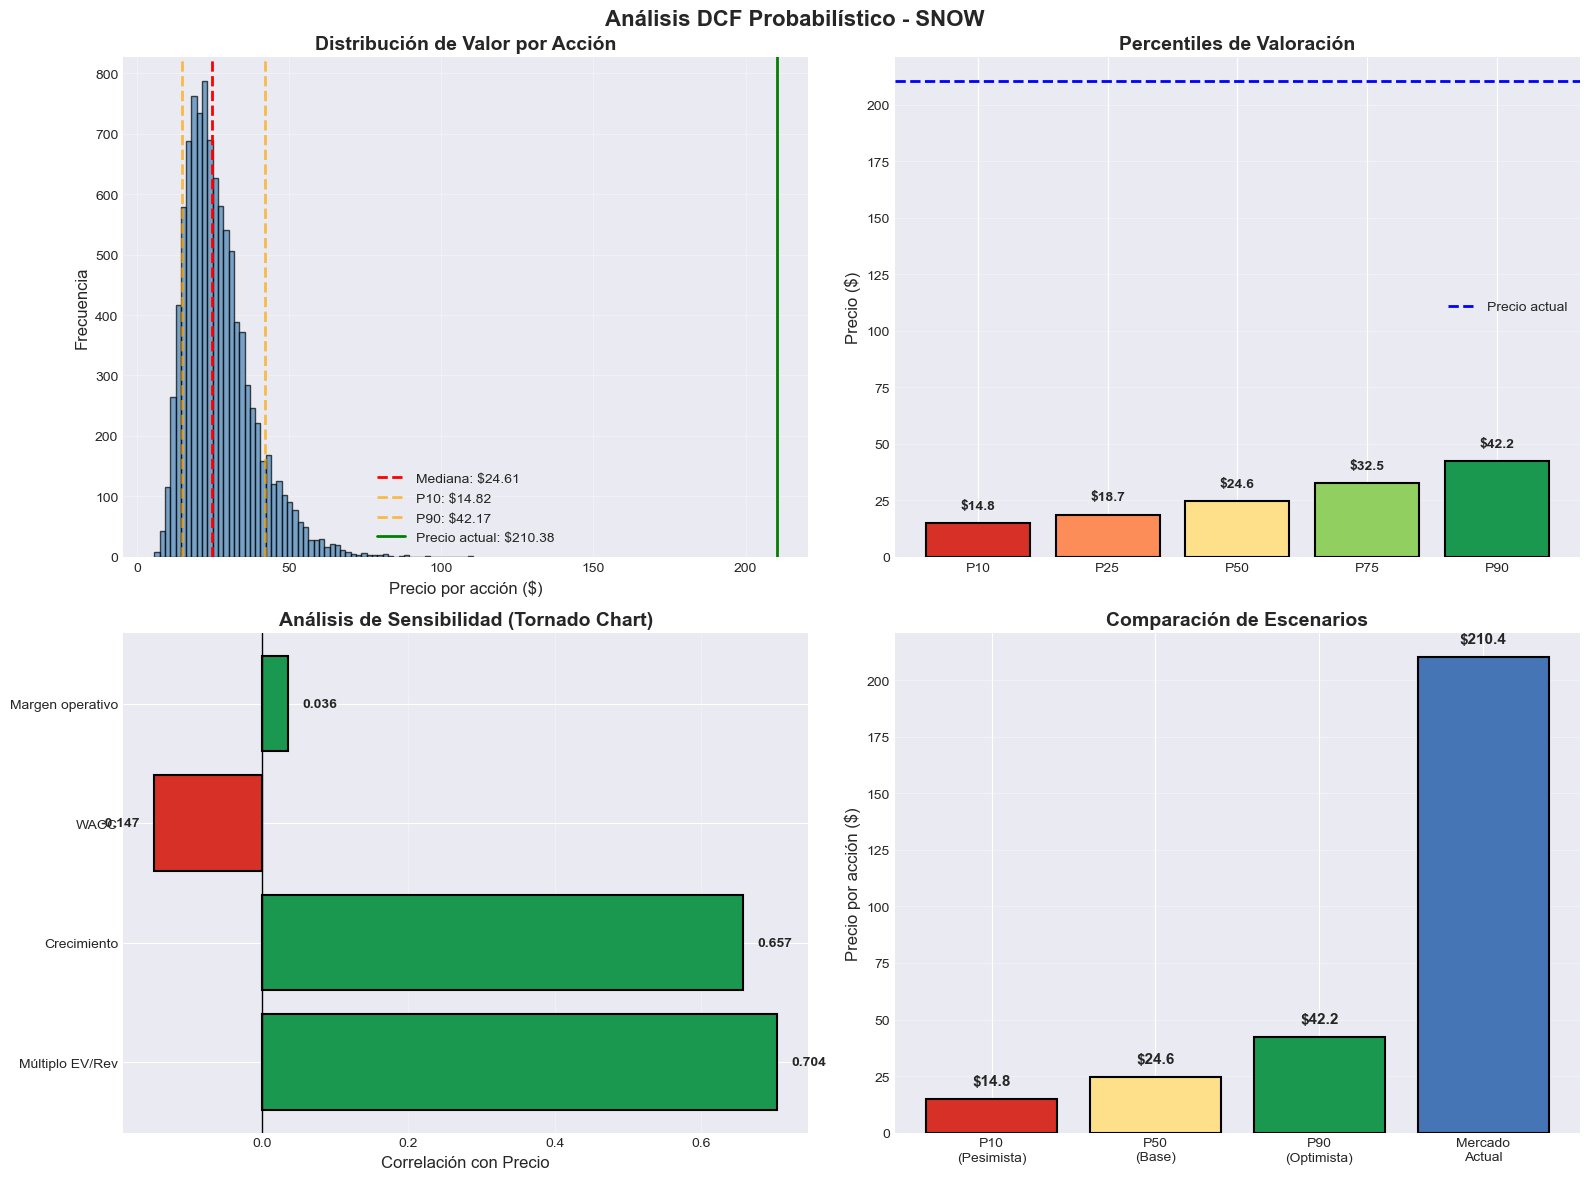

In [16]:
# ============================================================================
# 5. VISUALIZACIONES
# ============================================================================

print("\n" + "=" * 70)
print("GENERANDO VISUALIZACIONES...")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Análisis DCF Probabilístico - {empresa["ticker"]}', 
             fontsize=16, fontweight='bold')
# ============================================================================
# Gráfico 1: Distribución de precios
# ============================================================================
ax1 = axes[0, 0]
ax1.hist(precios, bins=60, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(np.median(precios), color='red', linestyle='--', linewidth=2, 
            label=f'Mediana: ${np.median(precios):.2f}')
ax1.axvline(np.percentile(precios, 10), color='orange', linestyle='--', 
            linewidth=2, alpha=0.7, label=f'P10: ${np.percentile(precios, 10):.2f}')
ax1.axvline(np.percentile(precios, 90), color='orange', linestyle='--', 
            linewidth=2, alpha=0.7, label=f'P90: ${np.percentile(precios, 90):.2f}')
ax1.axvline(empresa['precio_actual'], color='green', linestyle='-', 
            linewidth=2, label=f'Precio actual: ${empresa["precio_actual"]:.2f}')
ax1.set_xlabel('Precio por acción ($)', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_title('Distribución de Valor por Acción', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
# ============================================================================
# Gráfico 2: Box plot de percentiles
# ============================================================================
ax2 = axes[0, 1]
percentiles = [10, 25, 50, 75, 90]
valores_percentiles = [np.percentile(precios, p) for p in percentiles]

colors = ['#d73027', '#fc8d59', '#fee08b', '#91cf60', '#1a9850']
bars = ax2.bar(range(len(percentiles)), valores_percentiles, color=colors, 
               edgecolor='black', linewidth=1.5)
ax2.axhline(empresa['precio_actual'], color='blue', linestyle='--', 
            linewidth=2, label='Precio actual')
ax2.set_xticks(range(len(percentiles)))
ax2.set_xticklabels([f'P{p}' for p in percentiles])
ax2.set_ylabel('Precio ($)', fontsize=12)
ax2.set_title('Percentiles de Valoración', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars, valores_percentiles)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'${val:.1f}', ha='center', va='bottom', fontweight='bold')

# ============================================================================
# Gráfico 3: Análisis de sensibilidad (Tornado Chart)
# ============================================================================
ax3 = axes[1, 0]

# Calcular correlaciones de Spearman (más robusto que Pearson)
from scipy.stats import spearmanr

params = resultados_mc['parametros']
correlaciones = {
    'Crecimiento': spearmanr(params['growth'], precios)[0],
    'Margen operativo': spearmanr(params['margen'], precios)[0],
    'Múltiplo EV/Rev': spearmanr(params['multiple'], precios)[0],
    'WACC': spearmanr(params['wacc'], precios)[0]
}

# Ordenar por valor absoluto
correlaciones_ordenadas = dict(sorted(correlaciones.items(), 
                                     key=lambda x: abs(x[1]), 
                                     reverse=True))

nombres = list(correlaciones_ordenadas.keys())
valores = list(correlaciones_ordenadas.values())
colores_tornado = ['#d73027' if v < 0 else '#1a9850' for v in valores]

y_pos = np.arange(len(nombres))
ax3.barh(y_pos, valores, color=colores_tornado, edgecolor='black', linewidth=1.5)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(nombres)
ax3.set_xlabel('Correlación con Precio', fontsize=12)
ax3.set_title('Análisis de Sensibilidad (Tornado Chart)', fontsize=14, fontweight='bold')
ax3.axvline(0, color='black', linewidth=1)
ax3.grid(True, alpha=0.3, axis='x')

# Añadir valores
for i, v in enumerate(valores):
    ax3.text(v + 0.02 if v > 0 else v - 0.02, i, f'{v:.3f}', 
             va='center', ha='left' if v > 0 else 'right', fontweight='bold')


# ============================================================================
# Gráfico 4: Escenarios comparativos
# ============================================================================
ax4 = axes[1, 1]

escenarios_nombres = ['P10\n(Pesimista)', 'P50\n(Base)', 'P90\n(Optimista)', 'Mercado\nActual']
escenarios_valores = [
    np.percentile(precios, 10),
    np.percentile(precios, 50),
    np.percentile(precios, 90),
    empresa['precio_actual']
]
colores_escenarios = ['#d73027', '#fee08b', '#1a9850', '#4575b4']

bars = ax4.bar(range(len(escenarios_nombres)), escenarios_valores, 
               color=colores_escenarios, edgecolor='black', linewidth=1.5)
ax4.set_xticks(range(len(escenarios_nombres)))
ax4.set_xticklabels(escenarios_nombres)
ax4.set_ylabel('Precio por acción ($)', fontsize=12)
ax4.set_title('Comparación de Escenarios', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, val in zip(bars, escenarios_valores):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'${val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('dcf_probabilistico_analisis.png', dpi=300, bbox_inches='tight')
print("\n✅ Gráfico guardado: dcf_probabilistico_analisis.png")
plt.show()

In [17]:
# ============================================================================
# 6. TABLA RESUMEN FINAL
# ============================================================================

print("\n" + "=" * 70)
print("RESUMEN EJECUTIVO")
print("=" * 70)

resumen_df = pd.DataFrame({
    'Métrica': [
        'Precio actual de mercado',
        'Valor medio (Monte Carlo)',
        'Valor mediano (Monte Carlo)',
        'Rango P10-P90',
        'Probabilidad precio actual < valoración',
        'Upside potencial (vs P50)',
        'Downside potencial (vs P10)'
    ],
    'Valor': [
        f"${empresa['precio_actual']:.2f}",
        f"${np.mean(precios):.2f}",
        f"${np.median(precios):.2f}",
        f"${np.percentile(precios, 10):.2f} - ${np.percentile(precios, 90):.2f}",
        f"{(1 - percentil_mercado/100)*100:.1f}%",
        f"{(np.median(precios)/empresa['precio_actual'] - 1)*100:+.1f}%",
        f"{(np.percentile(precios, 10)/empresa['precio_actual'] - 1)*100:+.1f}%"
    ]
})

print("\n" + resumen_df.to_string(index=False))

print("\n" + "=" * 70)
print("🎓 CONCLUSIONES CLAVE")
print("=" * 70)
print("""
1. La valuación NO es un número único, es una DISTRIBUCIÓN
2. Los parámetros más importantes son: crecimiento y múltiplo de salida
3. El mercado puede estar sobre/subvaluado comparado con fundamentales
4. Este enfoque es MÁS HONESTO que un DCF tradicional de punto único
5. Permite cuantificar el riesgo, no solo estimarlo cualitativamente
""")

print("\n✅ Análisis completado exitosamente!")
print(f"📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)


RESUMEN EJECUTIVO

                                Métrica           Valor
               Precio actual de mercado         $210.38
              Valor medio (Monte Carlo)          $26.85
            Valor mediano (Monte Carlo)          $24.61
                          Rango P10-P90 $14.82 - $42.17
Probabilidad precio actual < valoración            0.0%
              Upside potencial (vs P50)          -88.3%
            Downside potencial (vs P10)          -93.0%

🎓 CONCLUSIONES CLAVE

1. La valuación NO es un número único, es una DISTRIBUCIÓN
2. Los parámetros más importantes son: crecimiento y múltiplo de salida
3. El mercado puede estar sobre/subvaluado comparado con fundamentales
4. Este enfoque es MÁS HONESTO que un DCF tradicional de punto único
5. Permite cuantificar el riesgo, no solo estimarlo cualitativamente


✅ Análisis completado exitosamente!
📅 Fecha: 2026-01-17 01:32:15
